**PyTorch**

Dans ce tutoriel, on va explorer l'implémentation et l'apprentissage de deux réseaux de neurones en utlisant PyTorch afin de classifier des images.
Pour ce faire, on doit compléter les étapes suivantes:
- importation et traitement des données
- implémentation de modèles
- apprentissage de modèles
- validation et comparaison de modèles

**Modèles**

Le module ``torchvision.models`` propose plusieurs modèles préformés de l'état de l'art qui permettent d'effectuer plusieurs tâches de vision par ordinateur.

Ici, on va utiliser le modèle **ResNet18**. Il s'agit d'un réseau de neurones convolutif de 18 couches de profondeur. Les couches profondes utilisent les résidus des couches précédentes, d'où vient son nom *Residual Network*. Cette technique permet d'éviter le problème de *Vanishing Gradient* qui limite la performance des réseaux profonds.

Durant l'apprentissage, le réseau traitera l'entrée à travers toutes les couches et retournera une distribution de probabilité sur toutes les classes possibles. Ensuite, on calculera une fonction de perte qui permet d'estimer l'erreur de la prédiction du réseau. Enfin, la propagation des gradients dans le réseau permettra d'optimiser les paramètres des différenetes couches.

Pour ce faire, deux fonctions sont indispensables: **forward** et **backward**.
- La fonction backward calcule les gradients des paramètres et les fait propager dans le réseau. On définit notre réseau de neurones comme une sous-classe de nn.Module. Cela permet d'hériter la fonction backward. 
- Ainsi, il suffit de définir la fonction forward qui calcule la sortie du réseau.

In [1]:
import torch.nn as nn
from torchvision import models

class ResNet(nn.Module):

  def __init__(self, class_num=2, architecture="resnet18", pretrained=True):
    super(ResNet,self).__init__()
    self.pretrained = pretrained
    model = models.resnet18(pretrained=pretrained)
    fc_input_dim = model.fc.in_features
    #change the dimension of output
    model.fc = nn.Linear(fc_input_dim, class_num)
    self.model = model
  def forward(self, x):
    x = self.model(x)
    return x


Ensuite, on va construire un autre réseau moins profond que ResNet.
On utilisera la fonction **ReLU** pour l'activation de neurones dans toutes les couches sauf pour la dernière où on utilisera **Softmax** qui permet de calculer la distributions de probabilité.

Ce réseau est composé de ces couches:
- ``torch.nn.Conv2d``: C'est une couche de convolution bidimensionnelle. Elle est caractérisée par son approche locale de traiter les données, ce qui permet d'extraire les motifs et les caractéristiques. 
- ``torch.nn.MaxPool2d``: Une limitation des couches de convolution est le fait qu'il marquent une position précise de caractéristiques. Cela signifie que de petits mouvements dans la position de l'objet dans l'image d'entrée entraîneront une sortie différente. Pour résoudre à cela, on utilise une technique de sous-échantillonnage appelée **Pooling** qui donne en sortie un signal de résolution plus petite que celle de l'entrée tout en gardant les éléments importants. Ici, on utilise le **Max Pooling** où on extrait la caractéristique ayant la plus grande amplitude en utilisant une fenêtre mobile.  
- ``torch.nn.Linear``: Cette couche est une couche linéaire entièrement connectée. Dans un CNN, on utilise une telle couche généralement en aval du réseau pour calculer les probabilités.
- ``torch.nn.BatchNorm2d`` et ``torch.nn.BatchNorm1d(n)``: cette couche est une implémentation de la méthode de **normalisation de lot**. Cette méthode consiste à normaliser chaque lot et d'injecter le résultat dans une fonction affine dont les paramètres sont appris durant la phase d'apprentissage. Cela permet de stabiliser les gradients et ainsi d'accélérer l'apprentissage remarquablement.
- ``torch.nn.Dropout``: c'est une implémentation de la technique de **décrochage**. Elle consiste à supprimer temporairement de neurones aléatoires du réseau durant la phase d'apprentissage. Cela permet de réduire le suraprentissage du modèle en évitant les co-adaptations de neurones sur les données d'entrainement. 



In [2]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, class_num=2, dropout=0.5):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2))
            
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU())
        
        self.conv6 = nn.Sequential(nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Linear(200704,1024),
                                 nn.BatchNorm1d(1024),
                                 nn.ReLU(),
                                 nn.Dropout(p=dropout))
        
        self.fc2 = nn.Sequential(nn.Linear(1024, 512),
                                 nn.BatchNorm1d(512),
                                 nn.ReLU(),
                                 nn.Dropout(p=dropout))
        self.linear = nn.Linear(512, class_num)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.linear(x)
        return x

**Initialisation de poids et biais**

Le module ``torch.nn.init`` propose plusieurs méthodes pour initaliser les poids du réseau. Ici, on utilisera le méthode de Xavier uniforme pour initialiser les poids de couches de convolution. Cette méthode prend en compte le nombre de neurones dans chaque couche et ainsi permet d'adapter les poids initiaux. Cela permet d'éviter certains problèmes de gradients que peuvent engendrer une initialisation complètement aléatoire dans les premières étapes d'apprentissage.

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.normal_(0.0, 0.01)

**Données**

Ici, on va utiliser une base de données qui contient des images de plats différents. Notre objectif est de faire une classfication binaire pour vérifier si une image représente une pizza. La base de données contient 1900 images, que l'on va diviser en deux ensembles: **ensemble d'apprentissage** et **ensemble de validation**.
Les images sont de type *RGB*, de largeur 384 et d'hauteur 512. 

On commence par définir des transformations de données. Dans le déploiement, le modèle sera appliqué sur des données du monde réel qui pourraient contenir du bruit. Cela réduit la performance du réseau. Pour résoudre à cela, on utilise une méthode nommée **augmentation des données**. Elle consiste à appliquer des transformations aléatoires sur les données d'apprentissage pour que l'apprentissage soit plus général. Ici, on rogne aléatoirement les images en utilisant la méthode ``TF.crop``. 

Le modèle ResNet prend en entrée des tenseurs de réels dans l'intervalle [-1, 1]. Donc, on transforme les images à des tenseurs et on les normalisent.

PyTorch propose une classe abstraite ``torch.utils.data.Dataset`` qui permet de charger et manoeuvrer la base de données. On prend usage de cette classe et donc on doit surcharger deux méthodes: ``__get_item__`` et ``__len__``.

Pour obtenir l'accès aux données et les mettre en mémoire, on utilise la classe ``torch.utils.data.DataLoader``. DataLoader dans Pytorch encapsule un ensemble de données et donne accès aux données sous-jacentes. Ce wrapper contiendra des batchs d'images par taille de batch définie.


In [ ]:
#télécharger les données
import boto3
import os
s3 = boto3.client('s3',endpoint_url='https://minio.lab.sspcloud.fr/')
s3.download_file(Bucket="mbenxsalha", Key="diffusion/pizza-not-pizza.zip", Filename="data")
!unzip data
!rm data
!rm pizza_not_pizza/food101_subset.py

In [4]:
import random
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import torch.nn.functional as F

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

def is_image_file(filename):
  return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def load_image(path):
  img = Image.open(path).convert("RGB")
  return img

def make_dataset(root):
  pizza_path = os.path.join(root,"pizza")
  not_pizza_path = os.path.join(root,"not_pizza")
  data = []
  for img in os.listdir(pizza_path):
    path = os.path.join(pizza_path, img)
    data.append((path, 1))

  for img in os.listdir(not_pizza_path):
    path = os.path.join(not_pizza_path, img)
    data.append((path, 0))

  return data


In [5]:
from torch.utils.data import Dataset

class MyTransformer():
  def __init__(self, crop):
    self.crop = crop

  def __call__(self, img, rot=None):
    img = TF.resize(img, (256,256))
    img = TF.crop(img, self.crop[0], self.crop[1], 224, 224)
    img = TF.to_tensor(img)
    img = TF.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return img

class DatasetGenerator(Dataset):
    def __init__(self, root, transform=None):
        imgs = make_dataset(root)
        self.root = root
        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, index):
        path, lab = self.imgs[index]
        img = load_image(path)


        # If a custom transform is specified apply that transform
        if self.transform is not None:
            img = self.transform(img)
        else:  # Otherwise define a random one (random cropping)
            top = random.randint(0, 256 - 224)
            left = random.randint(0, 256 - 224)
            transform = MyTransformer([top, left])
            # Apply the transformation
            img = transform(img)
        return img, lab

    def __len__(self):
        return len(self.imgs)

In [6]:
from torch.utils.data import DataLoader, random_split

batch_size = 64
data_root = "pizza_not_pizza"

dataset = DatasetGenerator(data_root)
train_set_length = int(0.7 * len(dataset))
test_set_length = len(dataset) - train_set_length
#split the dataset 
train_set, test_set = random_split(dataset, [train_set_length, test_set_length])
#define loaders
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

**Optimisation**

``torch.optim`` propose plusieurs méthodes de descente de gradient. Ici, on utilisera **la descente de gradient stochastique (SGD)**. 
On inclut aussi la méthode de **dégradation des pondérations (weight decay)** qui est une technique de régularisation servant à limiter le surapprentissage du réseau.

le module ``torch.nn`` propose plusieurs fonctions de perte. Dans ce tutoriel, on utilise **l'entropie croisée** . La minimsation de cette fonction permettra de rapprocher la distribution de probabilité apprise par le modèle à la distribution réelle. 

On utilise le l'application **cuda** de Nvidia qui permet de paralléliser le calcul en utilisant le processeur graphique (GPU). Cela permet d'optimiser le temps d'exécution.

In [7]:
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn

class_num = 2

ce_loss=nn.CrossEntropyLoss()

#set hyperparameters
lr = 0.001
weight_decay = 0.0005

#set device to cuda if nvidia gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
#initialize models

resnet = ResNet(class_num=class_num)
resnet = resnet.to(device)

network = Network(class_num=class_num)
network = network.to(device)
network.apply(weights_init)


#define optimizers
opt_resnet = optim.SGD(resnet.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
opt_network = optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)


/opt/mamba/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Apprentissage**

Pour former le modèle, on doit boucler sur l'itérateur de données, alimenter les entrées aux réseaux et optimiser les paramètres. 

``tqdm`` permet d'afficher une barre de progression

In [8]:
from tqdm import tqdm

loss_resnet, loss_network = [], []
epoch = 20
resnet.train()
network.train
torch.set_grad_enabled(True)

for epo in range(1,epoch+1):
  correct_resnet, correct_network = 0, 0
  print("Epoch {}/{} \n".format(epo, epoch))
  with tqdm(total=len(train_loader), desc="Train") as pb:
    for batch_num, (img, img_label) in enumerate(train_loader):
      opt_resnet.zero_grad()
      opt_network.zero_grad()
        
      img = img.to(device) 
      img_label = img_label.to(device)
        
      outputs = resnet(img)
      correct_resnet += (torch.argmax(outputs, dim=1)==img_label).sum().item()
      loss = ce_loss(outputs, img_label)
      loss.backward()
      loss_resnet.append(loss)
        
      outputs = network(img)
      correct_network += (torch.argmax(outputs, dim=1)==img_label).sum().item()
      loss = ce_loss(outputs, img_label)
      loss.backward()
      loss_network.append(loss)
        
      opt_resnet.step()
      opt_network.step()
      pb.update(1)

Epoch 1/20 



Train: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch 2/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epoch 3/20 



Train: 100%|██████████| 22/22 [00:19<00:00,  1.10it/s]


Epoch 4/20 



Train: 100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


Epoch 5/20 



Train: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


Epoch 6/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


Epoch 7/20 



Train: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch 8/20 



Train: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch 9/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


Epoch 10/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch 11/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epoch 12/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epoch 13/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epoch 14/20 



Train: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch 15/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch 16/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


Epoch 17/20 



Train: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch 18/20 



Train: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch 19/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


Epoch 20/20 



Train: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


**Evaluation**

La dernière étape consiste à évaluer le modèle sur l'ensemble de test.
Avant de commencer, on met le modèle sur le mode d'évaluation avec ``model.eval()`` pour geler les paramètres.

In [11]:
from tqdm import tqdm
correct_resnet, correct_network, num_predictions = 0, 0, 0
with tqdm(total=len(test_loader), desc="Test") as pb:
  resnet.eval()
  network.eval()
  for batch_num, (img, img_label) in enumerate(test_loader):
    img = img.to(device)
    img_label = img_label.to(device)
    predictions = resnet(img)
    correct_resnet += (torch.argmax(predictions, dim=1)==img_label).sum().item()
    predictions = network(img)
    correct_network += (torch.argmax(predictions, dim=1)==img_label).sum().item()
    num_predictions += predictions.shape[0]
    pb.update(1)

accuracy_resnet = correct_resnet / num_predictions
accuracy_network = correct_network / num_predictions
print("\n ResNet's Accuracy: {} \n Our network's accuracy: {}".format(accuracy_resnet, accuracy_network))

Test: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


 ResNet's Accuracy: 0.9271186440677966 
 Our network's accuracy: 0.8169491525423729


On voit que la précision de ResNet est beaucoup plus haute que celle de notre réseau. Cela s'explique par le fait que ResNet est prétrainé

Ici, on affiche l'évolution de la perte durant l'apprentissage pour chaque modèle.

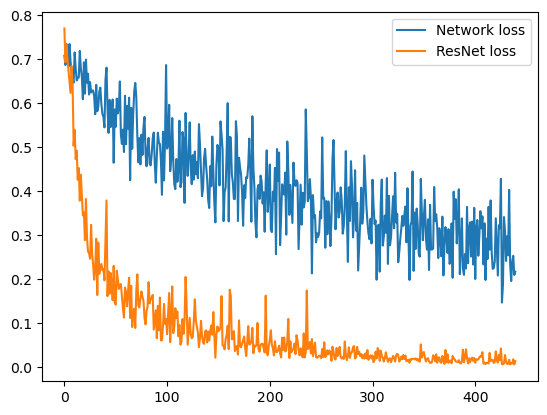

In [13]:
import matplotlib.pyplot as plt
iterations = list(range(len(loss_resnet)))
plt.plot(iterations, loss_network, label="Network loss")
plt.plot(iterations, loss_resnet, label="ResNet loss")
plt.legend()

                  

**Enregistrement du modèle**

Enfin, on enregistre le modèle pour l'exploiter après

In [ ]:
torch.save(network.state_dict(), "network.pth")